# Recommendations

In the following notebook we will attempt to determine the recommendations for some specified users. In other words we will pick some random users and get movie recommendations for them.

The **movielens** dataset contains real movie preference data used for a variety of algorithmic tests
(There are other datasets available as well at http://grouplens.org/datasets/ .) In this case we will use this small data set (see [README](http://files.grouplens.org/datasets/movielens/ml-100k/README)) at this url<br>
http://files.grouplens.org/datasets/movielens/ml-100k/<br>
Here are just two of the files:

    u.item: list containing movie ids and titles (plus other info)
    u.data: contains 100,000 ratings  (user id, movie id, rating, timestamp)

### Get the movies

The first line of `u.item` has '|'-delimited fields, starting with

    1|Toy Story (1995)|01-Jan-1995|...
    ...

Only the first two fields will be used here, so it can be loaded into a `movies` dict as

In [1]:
movies={}
for line in open('ml-data/u.item'):
    (id,title)=line.split('|')[0:2]
    movies[int(id)] = title

let's check how many movies there are in the dictionary

In [2]:
len(movies)

1682

### Get the data containing the ratings

The file `u.data` has a list of tab-delimited user_id/movie_id/rating/timestamp lines

    196     242     3       881250949
    186     302     3       891717742
    ...

and can be loaded into a `ratings` dict as 

In [3]:
ratings={}
for line in open('ml-data/u.data'):
    (user,movieid,rating,ts)=line.split('\t')
    user=int(user)
    movieid= int(movieid)
    if user not in ratings: ratings[user] = {}
    ratings[user][movies[movieid]]=float(rating)

How many users?

In [4]:
len(ratings)

943

### Before we start let's show a small sample, just to have an idea

A dictionary of movie reviewers and their ratings of a small set of movies

In [5]:
reviews={
    'Lisa Rose':
        {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.5, 'Just My Luck': 3.0,
         'Superman Returns': 3.5, 'You, Me and Dupree': 2.5, 'The Night Listener': 3.0},
    'Gene Seymour':
        {'Lady in the Water': 3.0, 'Snakes on a Plane': 3.5, 'Just My Luck': 1.5,
         'Superman Returns': 5.0, 'The Night Listener': 3.0, 'You, Me and Dupree': 3.5}, 
    'Michael Phillips':
        {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.0,
         'Superman Returns': 3.5, 'The Night Listener': 4.0},
    'Claudia Puig':
        {'Snakes on a Plane': 3.5, 'Just My Luck': 3.0, 'The Night Listener': 4.5,
         'Superman Returns': 4.0, 'You, Me and Dupree': 2.5},
    'Mick LaSalle':
         {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0, 'Just My Luck': 2.0,
          'Superman Returns': 3.0, 'The Night Listener': 3.0, 'You, Me and Dupree': 2.0}, 
    'Jack Matthews':
        {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
         'The Night Listener': 3.0, 'Superman Returns': 5.0, 'You, Me and Dupree': 3.5},
    'Toby':
        {'Snakes on a Plane':4.5,'You, Me and Dupree':1.0,'Superman Returns':4.0}
}

Hmm, what has **Toby** reviewed?

In [6]:
reviews['Toby']

{'Snakes on a Plane': 4.5, 'Superman Returns': 4.0, 'You, Me and Dupree': 1.0}

### Import libraries

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats import pearsonr,spearmanr,linregress

Out of curiosity, let's see how many they rated.

min=19, max=736, mean=105.72, std=100.57, median=64.0


(1, 250)

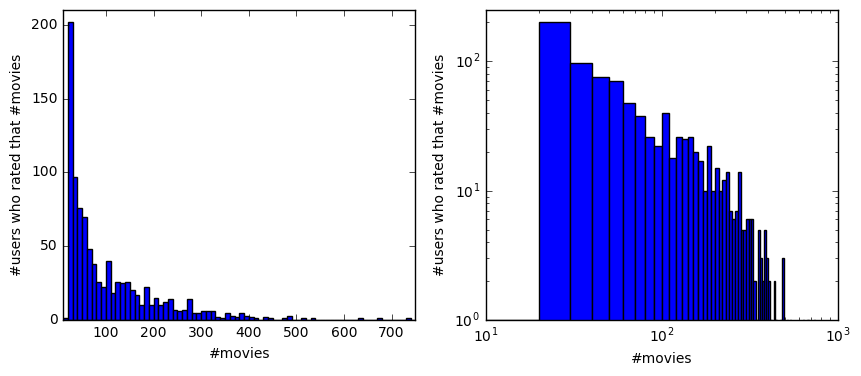

In [8]:
data=list(map(len,ratings.values()))
print('min={}, max={}, mean={:.2f}, std={:.2f}, median={}'.format(
        min(data),max(data),np.mean(data),np.std(data),np.median(data)))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.xlabel('#movies'),plt.ylabel('#users who rated that #movies')
plt.hist(data,bins=range(0,800,10))
plt.xlim(10,750),plt.ylim(0,210)

plt.subplot(1,2,2)
plt.xlabel('#movies'),plt.ylabel('#users who rated that #movies')
plt.hist(data,bins=range(0,800,10),log=True)
plt.xscale('log')
plt.ylim(1,250)

The result, a rough power law, is ratings of 1682 movies by 943 users, an average of about 106 ratings per user (ranging from 19 to 736, with a median of 64).

### Define functions

Next, we'll define the similarity measure function $s_{ij}=\frac {1}{1 + d^{2}_{ij}}$. It returns the similarity score of two reviewers.

In [9]:
def sim_pearson(prefs,crit1,crit2):
    shared_items=[item for item in prefs[crit1] if item in prefs[crit2]]
    #shared_items=list(set(prefs[person1]) & set(prefs[person2]))  #equivalent
    if len(shared_items)==0: return 0
    xdata = [prefs[crit1][item] for item in shared_items]
    ydata = [prefs[crit2][item] for item in shared_items]
    r,p=stats.pearsonr(xdata,ydata)
    if np.isnan(r): return 0
    return r

We also need to define another function to get recommendations by using a weighted average of every other person's ratings, weighted according to that person's similarity to another person. Suppose person $i$ has similarity $s_i$ to you, and gives rating ${r_i(m)}$ to movie $m$ that you haven't seen, then that person will contribute ${s_i⋅r_i(m)}$ to your likely preference for movie $m$, so that others' ratings are weighted in proportion to their similarity to you. Then we sum on $i$ over all those who have rated movie $m$, and divide by the same sum over the $s_i$ to give the expected value of your rating of movie $m$:

$$ E[r_m] = \frac{\sum_{i\:|\:i\:rated\:m} s_i \cdot  r_m(i)}{\sum_{i\:|\:i\:rated\:m} s_i} $$

This equation is implemented in the function below, and gives the expected rating of all movies one hasn't seen:

In [10]:
def getRecommendations(prefs,person,similarity=sim_pearson):
    totals={}
    simSums={}
    for other in prefs:
        # don't compare me to myself
        if other==person: continue
        sim=similarity(prefs,person,other)
    
        # ignore scores of zero or lower
        if sim<=0: continue
        for item in prefs[other]:

            # only score movies I haven't seen yet
            if item not in prefs[person] or prefs[person][item]==0:
                # Similarity * Score
                if item not in totals:
                    totals[item]=0
                    simSums[item]=0
                totals[item] += prefs[other][item]*sim
                # Sum of similarities
                simSums[item] += sim

    # Create the normalized list
    rankings=[(item,round(totals[item]/simSums[item],3)) for item in totals]

    # Return the sorted list
    return sorted(rankings,key=lambda x:x[1],reverse=True)

### Let's play...

Now let's say we would like to view the top ten recommendations for users 2 and 167. 

In [11]:
getRecommendations(ratings,2)[:10], getRecommendations(ratings,167)[:10]

([('Santa with Muscles (1996)', 5.0),
  ("Someone Else's America (1995)", 5.0),
  ('Star Kid (1997)', 5.0),
  ('Saint of Fort Washington, The (1993)', 5.0),
  ('Little City (1998)', 5.0),
  ('Great Day in Harlem, A (1994)', 5.0),
  ('Entertaining Angels: The Dorothy Day Story (1996)', 5.0),
  ('The Deadly Cure (1996)', 5.0),
  ('Prefontaine (1997)', 5.0),
  ('Marlene Dietrich: Shadow and Light (1996) ', 5.0)],
 [('Santa with Muscles (1996)', 5.0),
  ("Someone Else's America (1995)", 5.0),
  ('Saint of Fort Washington, The (1993)', 5.0),
  ('Little City (1998)', 5.0),
  ('They Made Me a Criminal (1939)', 5.0),
  ('Boys, Les (1997)', 5.0),
  ('Prefontaine (1997)', 5.0),
  ('Marlene Dietrich: Shadow and Light (1996) ', 5.0),
  ('Entertaining Angels: The Dorothy Day Story (1996)', 5.0),
  ('Great Day in Harlem, A (1994)', 5.0)])

Also we want to know their Pearson similarity

In [12]:
sim_pearson(ratings,2,167)

1.0

From above we can say that users 2 and 167 are highly correlated by Pearson, and get similar recommendations.

In [13]:
users3=(4,36,415)
[((u1,u2),sim_pearson(ratings,u1,u2)) for u1 in users3 for u2 in users3 if u1<u2]      

[((4, 36), -1.0), ((4, 415), -1.0), ((36, 415), 1.0)]

Users 36 and 415 are highly correlated, and both negatively correlated with user 4, and that is reflected in their recommendations.